## CS585: Natural Language Processing
### Neural Networks III

<br><br>
#### Illinois Institute of Technology  
#### Aron Culotta

<br><br><br><br><br>

#### Derivation of Neural Network Update Rule

Recall neural network:

![nn](figs/nn.png)

Output $y_j$ for input $\vec{x}$ is computed as:

$$y_j = \frac{1}{1 + e^{-\vec{h}\cdot\vec{\lambda_j}}} $$
where $\vec{h} = \{h_1 \ldots h_m\}$ and
$$
h_i = \frac{1}{1 + e^{-\vec{x}\cdot\vec{\theta}_i}}
$$

Following the traditional gradient descent recipe, we must:
- pick an error function
- compute the gradient w.r.t each weight
- update parameters iteratively in direction of gradient

<br><br>


### Optimizing the error function

Mean-squared error, for a single instance with true output vector $\vec{t} = \{t_1 \ldots t_k\}$:

$$
E = \frac{1}{2} \sum_k (t_k - y_k)^2
$$

then, we need to compute two gradients:
- $\frac{\partial E}{\partial{\theta_{ij}}}$
- $\frac{\partial E}{\partial{\lambda_{jk}}}$  
<br>
where   
- $\theta_{ij}$ is weight from input node $i$ to hidden unit $j$
- $\lambda_{jk}$ is the weight from hidden unit $j$ to output unit $k$

<br>
<br>
Skipping the calculus, we end up with the following update rules, where $\eta$ is the learning rate:

$$\lambda_{jk}^{t+1} = \lambda_{jk}^{t} + \eta \: h_j y_k (1-y_k)(t_k - y_k) $$  
$$\theta_{ij}^{t+1} = \theta_{ij}^t +  \eta \: x_i h_j(1-h_j) \sum_k \lambda_{jk}^t (t_k - y_k) y_k (1-y_k)  $$

These can be understood as assigning blame proportional to  
- the input unit (either $h_j$ for $\lambda_{jk}$ or $x_i$ for $\theta_{ij}$)
- the error $(t_k- y_k)$
- Note that the update to $\theta_{ij}$ considers the proportion of error attributable to hidden node $h_j$: $\sum_k \lambda_{jk}^t (t_k - y_k) y_k (1-y_k) $

<br>

Gradient descent in neural networks is often called <u> back-propagation</u>,  
since the errors/updates at layer $i$ are propagated back to layer $i-1$.

In [97]:
import math
from math import atan2,degrees,exp
import matplotlib.pyplot as plt
from numpy import array as npa
import numpy as np
%matplotlib inline


In [98]:
## For drawing a neural network.
def labelLine(ax, line, x, label, align=True):
    """
    Adapted from http://stackoverflow.com/a/39402483
    """
    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    #Find corresponding y co-ordinate and angle
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break
            
    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0
    kwargs = {
        'ha': 'center',
        'va': 'center',
        'backgroundcolor': ax.get_facecolor(),
        'zorder': 5,
        'alpha': .8
    }
    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def display_nn(nn, show_delta=False):
    """
    Adapted from
    https://gist.github.com/anbrjohn/7116fa0b59248375cd0c0371d6107a59
    """
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    left = bottom = .1
    right = top = .9 
    layers = nn.layers
    layer_sizes = [nn.n_input, nn.n_hidden, nn.n_output]
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    ax.axis('off')
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            x = n*h_spacing + left
            y = layer_top - m*v_spacing
            circle = plt.Circle((x,y), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Node annotations
            text = '%.4f' % layers[n][m].output
            plt.annotate(text, xy=(x, y), zorder=5, ha='center', va='center')
            if show_delta:
                plt.annotate('%.4f' % layers[n][m].delta, xy=(x, y-.02), zorder=5, ha='center', va='center', color='r')


    # Edges
    for n, (layer_a, layer_b) in enumerate(zip(layers[:-1], layers[1:])):#  zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_size_a = len(layer_a)
        layer_size_b = len(layer_b)
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k', lw=1)
                ax.add_artist(line)     
                # Edge annotations
                to_y = layer_top_b - o*v_spacing
                from_y = layer_top_a - m*v_spacing
                to_x = (n + 1)*h_spacing + left
                from_x = n*h_spacing + left
                rotation = math.degrees((to_y - from_y) / (to_x - from_x))
                labelLine(ax, line, to_x - .1,
                          label='%.3f' % layer_b[o].weights[m],
                          align=True)
    plt.show()

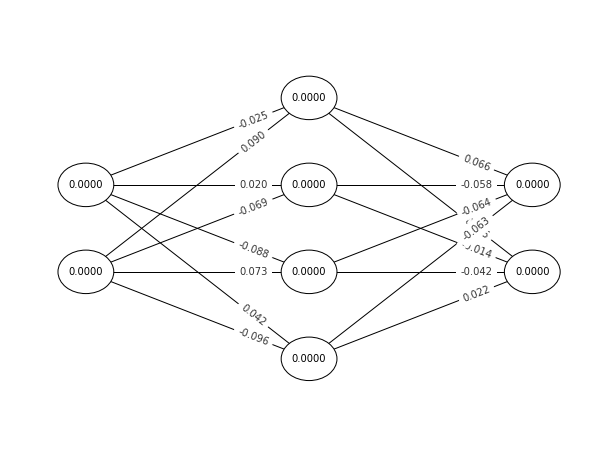

In [99]:
## Simple 3-layer neural network implementation
def random_vec(length):
    return np.random.uniform(-.1, .1, length)
    
def logistic(x, theta):
    return 1 / (1 + exp(-np.dot(x.T, theta)))

def transfer_derivative(output):
    return output * (1.0 - output)

class Neuron:
    def __init__(self, inputs, weights):
        self.inputs = inputs
        self.weights = weights
        self.output = 0
        self.delta = 0
        
    def activate(self):
        # note bias term implemented by
        # appending a '1' to all inputs.
        self.output = logistic(np.array([n.output for n in self.inputs] + [1]),
                               self.weights)
        return self.output
    
class InputNeuron:
    """
    Input neurons have no associated parameters.
    """
    def __init__(self, value):
        self.output = value
        self.delta = 0

class NeuralNetwork:
    def __init__(self, n_input, n_hidden, n_output, lrate, seed):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.lrate = lrate
        self.seed = seed
        np.random.seed(seed)
        
        # Initialize each layer.
        self.input_layer = [
            InputNeuron(0)
            for i in range(n_input)
        ]
        # note "bias" term added to each layer (n_input+1)
        self.hidden_layer = [
            Neuron(self.input_layer,
                   random_vec(n_input+1))
            for i in range(n_hidden)
        ]
        self.output_layer = [
            Neuron(self.hidden_layer,
                   random_vec(n_hidden+1))
            for i in range(n_output)
        ]
        self.layers = [self.input_layer, self.hidden_layer, self.output_layer]
        
    def predict(self, x):
        # Set input layer
        for n,xi in zip(self.input_layer, x):
            n.output = xi
        # Compute hidden layer
        for n in self.hidden_layer:
            n.activate()
        # Compute output layer
        for n in self.output_layer:
            n.activate()
        return np.array([n.output for n in self.output_layer])
                
    def back_prop_error(self, truth):
        errors = []
        # output layer delta: y_k(1-y_k) * (t_k - y_k)
        for j, n in enumerate(self.output_layer):
            n.delta = transfer_derivative(n.output) *  (truth[j] - n.output)
           
        # hidden layer delta: 
        # h_j(1-h_j) \sum_k \lambda_{jk}^t y_k (1-y_k) * (t_k - y_k) 
        for j, nj in enumerate(self.hidden_layer):
            error = sum(nj.weights[k] * nk.delta
                        for k, nk in enumerate(self.output_layer))
            nj.delta = error * transfer_derivative(nj.output)       
            
    def update_weights(self):
        # update hidden layer
        # \eta * \delta_j * x_i
        for j, nj in enumerate(self.hidden_layer):
            for i, ni in enumerate(self.input_layer):
                nj.weights[i] += self.lrate * nj.delta * ni.output
        # update output layer
        # \eta * \delta_k * h_j
        for k, nk in enumerate(self.output_layer):
            for j, nj in enumerate(self.hidden_layer):
                nk.weights[j] += self.lrate * nk.delta * nj.output

    def errors(self, inputs, outputs):
        total = 0
        for inp, outp in zip(inputs, outputs):
            self.predict(inp)
            total += sum((t-p.output)**2 for t,p in zip(outp, self.output_layer))
        return total
    
    def display(self, show_delta=False):
        display_nn(self, show_delta)

nn = NeuralNetwork(n_input=2, n_hidden=4, n_output=2, lrate=.5, seed=42)
nn.display()

iteration 1
prediction:


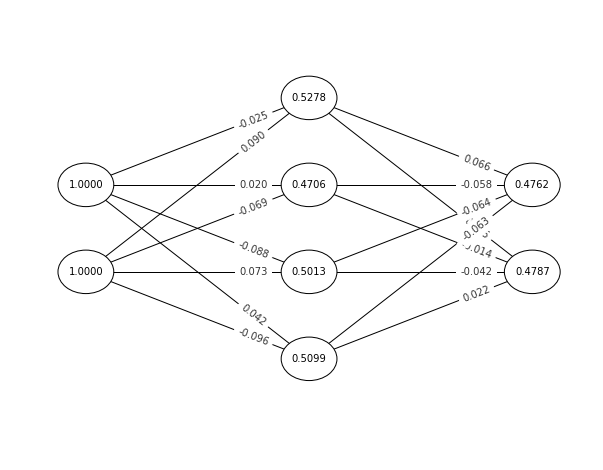

backprop:


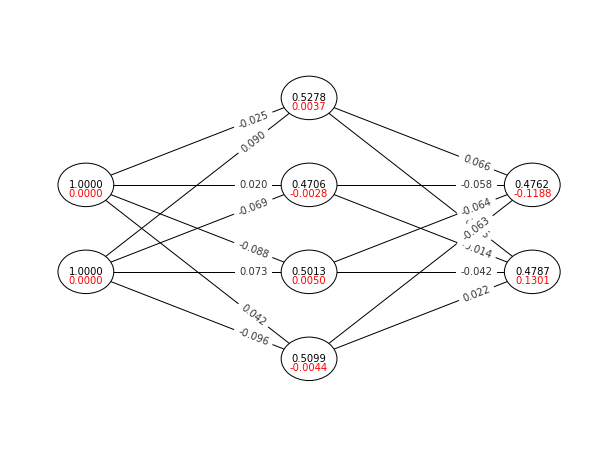

error=0.498552
updated weights


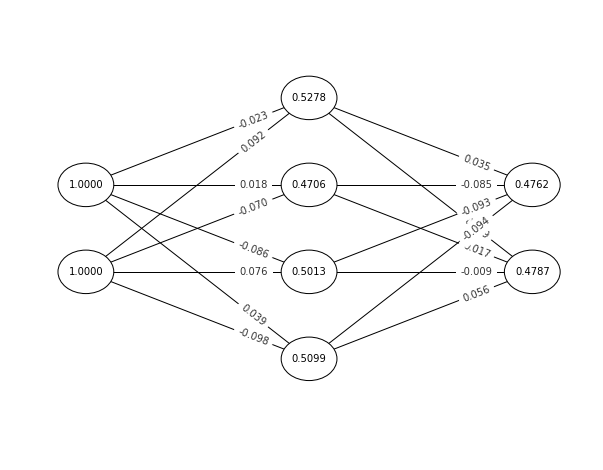

error=0.467697
iteration 2
prediction:


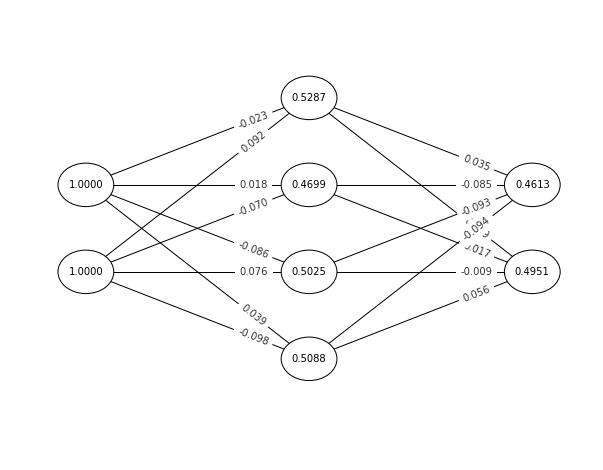

backprop:


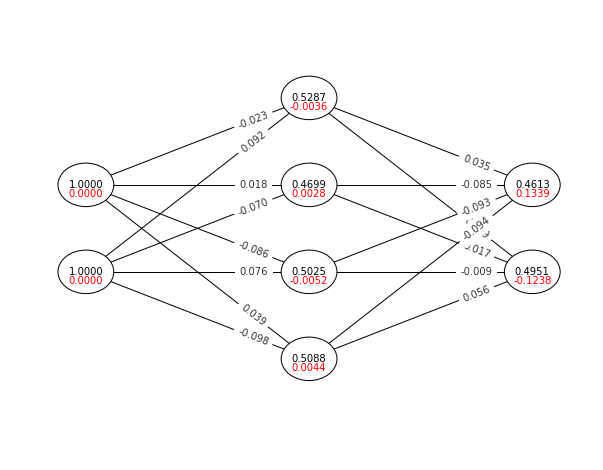

updated weights


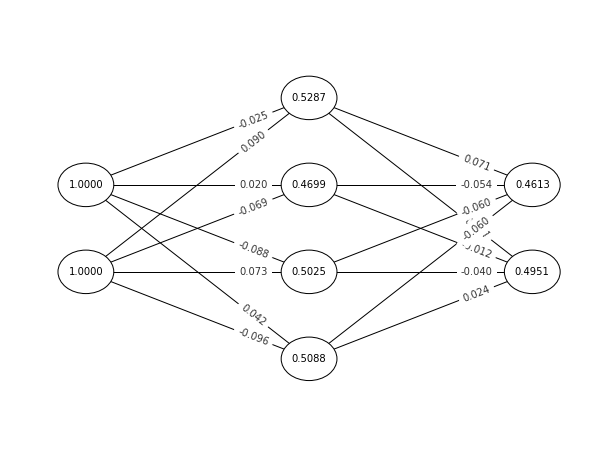

error=0.499544


In [100]:
##
## Learn function: f(x1, x2) = 1 iff x1=1 and x2=1
##
## y=[1,0] means 0, y=[0,1] means 1
## e.g.:
x = np.array([1, 1])
y = np.array([0, 1])  

print('iteration 1')
nn.predict(x)
print('prediction:')
nn.display()
nn.back_prop_error(y)
print('backprop:')
nn.display(show_delta=True)
print('error=%g' % nn.errors([x], [y]))
nn.update_weights()
print('updated weights')
nn.display()
print('error=%g' % nn.errors([x], [y]))

print('iteration 2')
nn.predict(np.array([1,1]))
print('prediction:')
nn.display()
nn.back_prop_error(np.array([1, 0]))
print('backprop:')
nn.display(show_delta=True)
nn.update_weights()
print('updated weights')
nn.display()
print('error=%g' % nn.errors([x], [y]))


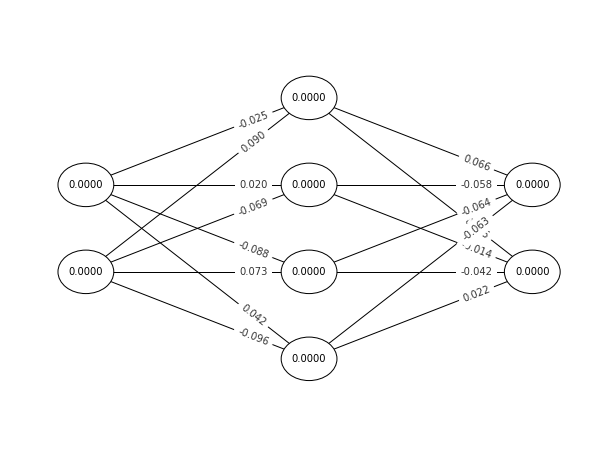

error=3.47646
error=3.23475
error=3.12285
error=3.06747
error=3.03838
error=3.02235
error=3.01318
error=3.00776
error=3.00445
error=3.00235
error=3.00095
error=2.99993
error=2.99912
error=2.99839
error=2.99768
error=2.99694
error=2.99612
error=2.9952
error=2.99418
error=2.99303
error=2.99174
error=2.9903
error=2.98871
error=2.98695
error=2.98502
error=2.98292
error=2.98063
error=2.97815
error=2.97548
error=2.9726
error=2.96952
error=2.96623
error=2.96272
error=2.95899
error=2.95503
error=2.95084
error=2.94642
error=2.94176
error=2.93685
error=2.9317
error=2.92629
error=2.92063
error=2.91471
error=2.90854
error=2.90209
error=2.89538
error=2.8884
error=2.88115
error=2.87362
error=2.86583
error=2.85775
error=2.8494
error=2.84077
error=2.83186
error=2.82267
error=2.81321
error=2.80347
error=2.79346
error=2.78317
error=2.77261
error=2.76178
error=2.75068
error=2.73932
error=2.72771
error=2.71583
error=2.70371
error=2.69134
error=2.67873
error=2.66589
error=2.65282
error=2.63953
error=2.6260

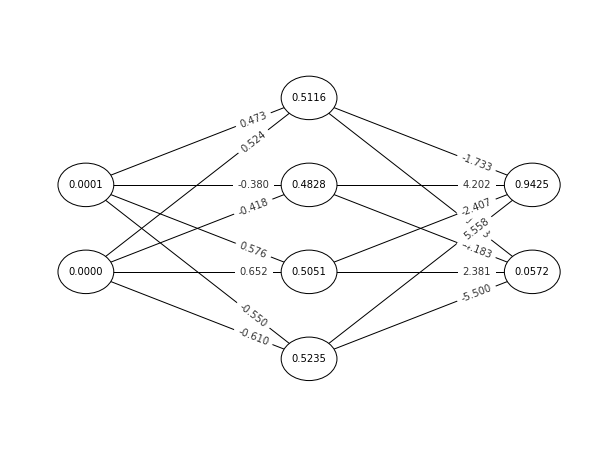

input: [  1.00000000e-05   1.00001000e+00]


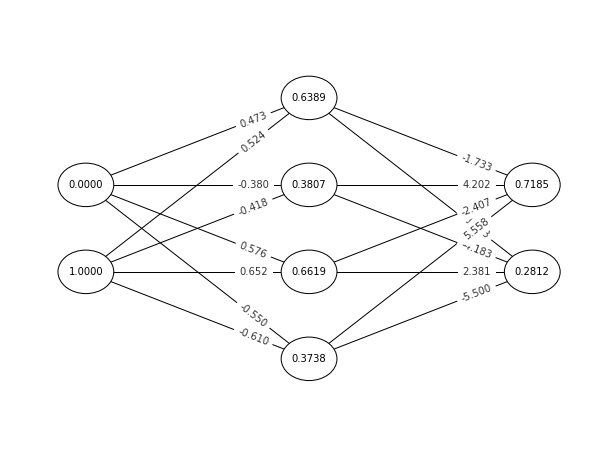

input: [  1.00100000e+00   1.00000000e-04]


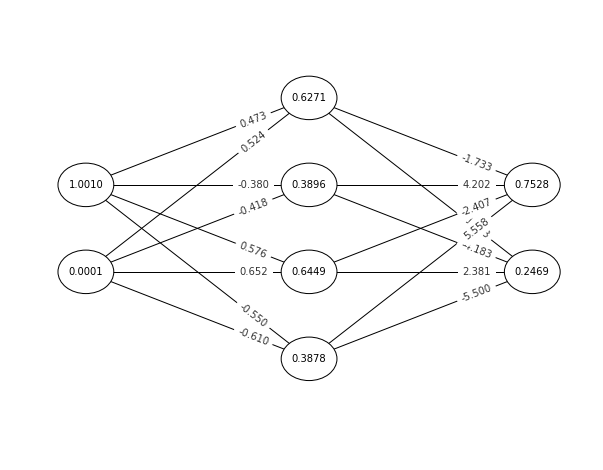

input: [ 1.001   1.0001]


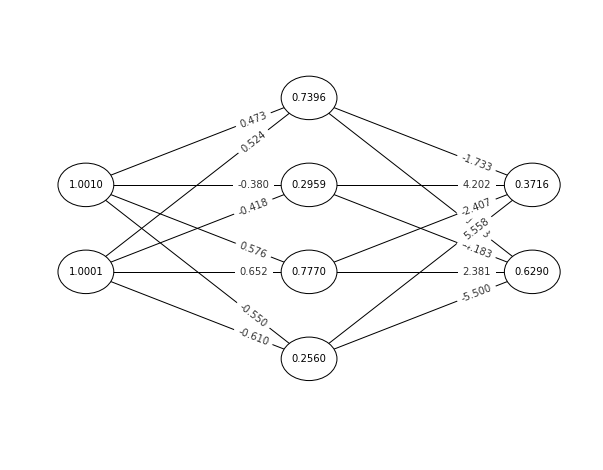

input: [  2.00000000e-04   2.00000000e-06]


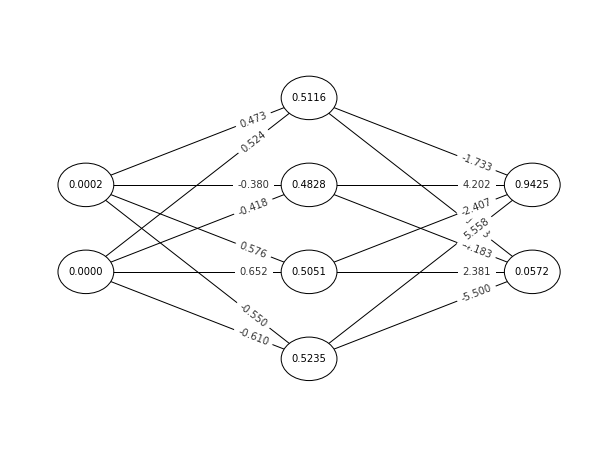

input: [  2.00000000e-05   1.00002000e+00]


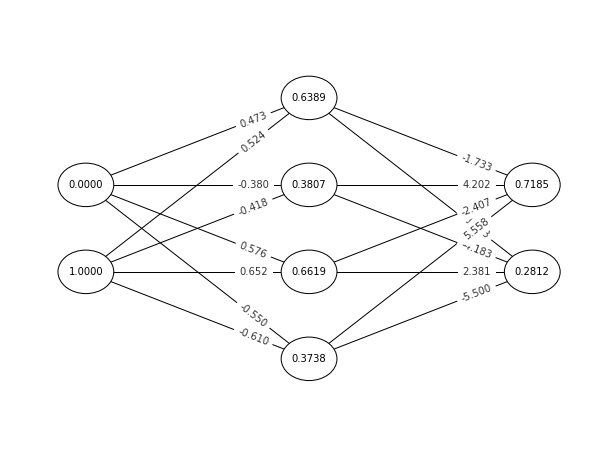

input: [  1.00200000e+00   2.00000000e-04]


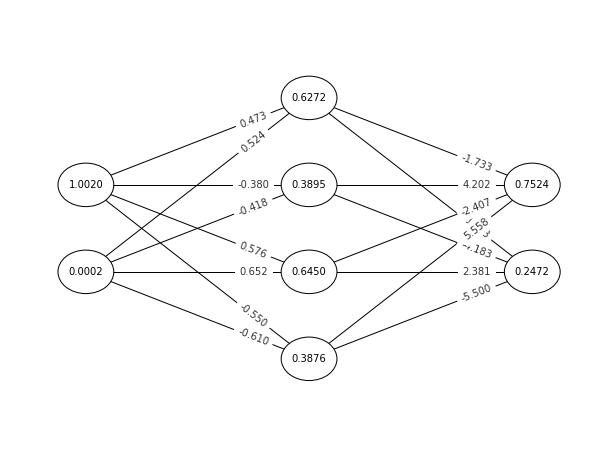

input: [ 1.002   1.0002]


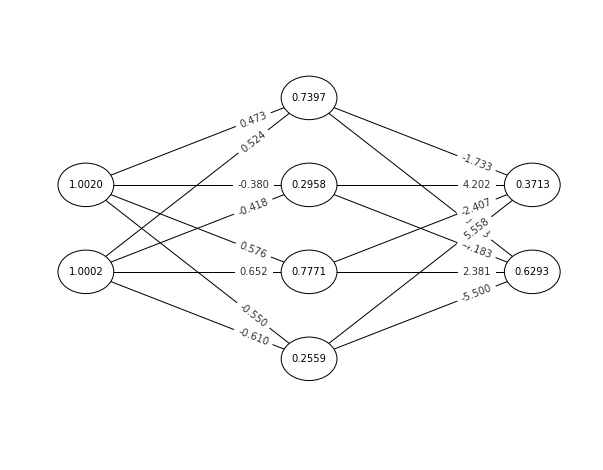

In [101]:
# Repeat for many iterations:
nn = NeuralNetwork(n_input=2, n_hidden=4, n_output=2, lrate=0.8, seed=42)
nn.display()

# 8 training instances.
data = [
        (npa([0.0001,.000001]), npa([1, 0])),
        (npa([0.00001,1.00001]), npa([1, 0])),
        (npa([1.0010,0.0001]), npa([1, 0])),
        (npa([1.001,1.0001]), npa([0,  1])),
        (npa([0.0002,.000002]), npa([1, 0])),
        (npa([0.00002,1.00002]), npa([1, 0])),
        (npa([1.0020,0.0002]), npa([1, 0])),
        (npa([1.002,1.0002]), npa([0,  1]))
    ]

for i in range(200):  # gradient descent iterations
    for inp, outp in data:
        nn.predict(inp)
        nn.back_prop_error(outp)
        nn.update_weights()
    print('error=%g' % nn.errors([x[0] for x in data], [x[1] for x in data]))

# print final predictions.
for input_vec, label in data:
    print('input:', input_vec)
    nn.predict(input_vec)
    nn.display()



<br><br>
The above implementation is for demonstration purposes only. To make it work in the real world, many changes are needed:

- Scalability:
  - store everything as sparse matrices
- Convergence:
  - momentum: update at iteration $t$ depends on update at $t-1$  
    $$\lambda_{jk}^{t+1} = \lambda_{jk}^t +  \alpha(\lambda_{jk}^t - \lambda_{jk}^{t-1}) + \eta \: h_j y_k (1-y_k)(t_k - y_k) $$  
    
  - The above does <u> stochastic gradient descent </u>: Parameters updated after each training instance.
  - Will get faster convergence for this problem if instead use <u>batch gradient descent</u>
    - Accumulate back-propagation errors for all instances
    - Then, update weights

- Overfitting:
  - early stopping: pick the number of gradient descent iterations by optimizing accuracy on  a <u> validation set</u>
  ![early](figs/early.png)

## More advanced architectures

There is an active research area investigating alternative neural network architectures for different problems.

We will look at a number of architectures designed for NLP applications.

E.g., learning word representations (word2vec):

![nn](../l17/figs/nn.png)

This has two hidden layers, where
- The first layer corresponds to a real-valued representation of each word
- The second layer combines the first layer to predict the context (e.g., the next word in the document)

## Recurrent Neural Networks

(adapted from [here](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/))

- Sequence model for neural networks
- Similar to Hidden Markov models

![rnn](figs/rnn.png)

- $x_t$: input at time  $t$.
  - E.g., a word.
- $s_t$: hidden state at time  $t$.
  - The “memory” of the network. 
  - $s_t$ is a function of the previous hidden state ($s_{t-1}$) and the current input ($x_t$).
    - Similar to HMMs, where we have $p(y_t \mid y_{t-1}, x_t)$
    - $s_t=f(Ux_t + Ws_{t-1})$
      - $f$ :  activation function (e.g., sigmoid, tanh, etc)
      - $U$: analogous to "emission" probabilities in HMMs
      - $W$: analogous to "transition" probabilities in HMMs
- $o_t$: output at time $t$
  - E.g., to predict the next word in a sentence it would be a vector of probabilities across our vocabulary. $o_t = \mathrm{softmax}(Vs_t).$


<br>
This "unrolled" network is a multi-layer neural net
- E.g., if the sentence has 5 words, we have 5 layers
- Unlike a typical neural net, the parameters are <u>shared</u> across layers
  - That is, $U$ and $V$ are the same everywhere.
  
<br><br>
Unlike HMMs, we will estimate parameters $U$ and $V$ with gradient descent (rather than counting)

## Types of supervision for Recurrent NNs

- One output per time step
  - E.g., part-of-speech tagging, named-entity recognition
- One output per sequence
  - E.g., document classification
  
  
## Backpropagation through time

- For a single sequence, we can compute back-propagation as in a standard neural net.
- However, because each input sequence has a different length, we have neural nets with different numbers of layers.
- To deal with this, we can collect all sequences of length $t$ and do training on them, the proceed to sequences of length $t+1$:


Repeat:

for $t=1 \ldots T\:\:\:$ ($T$=max length of any sequence):
  - Unfold your neural network in time for $t$ time steps to create a standard feed-forward net.
  - Perform forward and backward propagation as in a normal network.
  - Average all the gradients at each layer, so that the weight update to the matrices is the same in each time step.



####  sources
- http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5287721
- http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
- http://andrew.gibiansky.com/blog/machine-learning/recurrent-neural-networks/

In [1]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())